In [1]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [81]:
!pip install tqdm

In [44]:
random.seed(108)

ANNOTATION_PATH = "/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml"
IMAGE_PATH = "/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/img"

In [45]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            # print(elem.text)
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict


In [46]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"background": 0, "0": 1, "1": 2}

In [47]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width = (b["xmax"] - b["xmin"])
        b_height = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width /= image_w
        b_height /= image_h

        # Write the bbox details to the file
        print_buffer.append(
            "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join(ANNOTATION_PATH, info_dict["filename"].replace(".jpg",".txt"))

    # Save the annotation to disk
    print("\n".join(print_buffer), file=open(save_file_name, "w"))

In [48]:
# Get the annotations
annotations = [os.path.join(ANNOTATION_PATH, x) for x in os.listdir(ANNOTATION_PATH) if x[-3:] == "xml"]
annotations.sort()

In [49]:
len(annotations)

613

In [50]:
# # Convert and save the annotations
for ann in tqdm(annotations):
    # print(ann)
    info_dict = extract_info_from_xml(ann)
    # print(len(info_dict))
    convert_to_yolov5(info_dict)
annotations = [os.path.join(ANNOTATION_PATH, x) for x in os.listdir(ANNOTATION_PATH) if x[-3:] == "txt"]

100%|██████████| 613/613 [00:00<00:00, 4776.97it/s]


In [51]:
annotations

['/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00401.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00104.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00577.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00225.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00063.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00333.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00509.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00205.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00562.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00482.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00287.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00042.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00031.txt',
 '/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00314.txt',
 '/home/jun/Github/Data/Thesis-Dat

In [52]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))


def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h

    transformed_annotations[:, 1] = transformed_annotations[:, 1] - (transformed_annotations[:, 3] / 2)
    transformed_annotations[:, 2] = transformed_annotations[:, 2] - (transformed_annotations[:, 4] / 2)
    transformed_annotations[:, 3] = transformed_annotations[:, 1] + transformed_annotations[:, 3]
    transformed_annotations[:, 4] = transformed_annotations[:, 2] + transformed_annotations[:, 4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

In [53]:
# Get any random annotation file
annotation_file = random.choice(annotations)

In [54]:
annotation_file

'/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/xml/00094.txt'

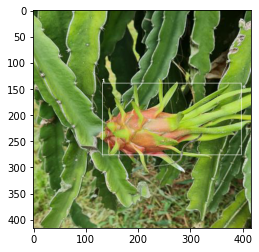

In [55]:

with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x] for x in annotation_list]

# Get the corresponding image file
image_file = annotation_file.replace("xml", "img").replace("txt", "jpg")
assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [56]:
DATA_PATH = "/home/jun/Github/Data/Thesis-Data/Ripe-Raw-ok/test/"

In [57]:
# Read images and annotations
images = [os.path.join(IMAGE_PATH, x) for x in os.listdir(DATA_PATH + 'img')]
annotations = [os.path.join(ANNOTATION_PATH, x) for x in os.listdir(DATA_PATH + 'xml') if x[-3:] == "txt"]

images.sort()
annotations.sort()


In [111]:
# # Split the dataset into train-valid-test splits
# train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
# val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

mkdir: cannot create directory ‘images/train’: No such file or directory
mkdir: cannot create directory ‘images/val’: No such file or directory
mkdir: cannot create directory ‘images/test’: No such file or directory
mkdir: cannot create directory ‘annotations/train’: No such file or directory
mkdir: cannot create directory ‘annotations/val’: No such file or directory
mkdir: cannot create directory ‘annotations/test’: No such file or directory


In [58]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False


In [59]:
# Move the splits into their folders
move_files_to_folder(images, 'images/test/')
move_files_to_folder(annotations, 'labels/test/')

In [128]:
!cd yolov5

In [62]:
!pwd

/home/jun/Github/FruitCountingEngine/Model/Yolo


In [61]:
!cd yolov5

In [12]:
!python train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data fruit.yaml --weights yolov5s.pt --workers 24 --name dragon-fruit


github: skipping check (not a git repository)
requirements: /home/jun/Github/FruitCountingEngine/Model/Yolo/requirements.txt not found, check failed.
YOLOv5 🚀 bb409c8 torch 1.12.0 CUDA:0 (NVIDIA GeForce GTX 1080, 8111.125MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=False, cfg='./yolov5/models/yolov5s.yaml', data='./yolov5/data/fruit.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='./yolov5/data/hyp.scratch.yaml', image_weights=False, img_size=[300, 300], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='dragon-fruit', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/dragon-fruit6', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='yolov5s.pt', workers=24, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/tra